In [1]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
from scipy import integrate
from numpy import loadtxt
import copy
import math
import pandas as pd

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams.update({'font.size': 11})

#### Load redshift bins and galaxy density n(z) for spectroscopic and photometric samples

https://arxiv.org/pdf/1308.4164.pdf

In [2]:
f=open('n_sp.txt',"r")
lines=f.readlines()
z=[]; n_spec=[]; n_phot=[]
for x in lines:
    z.append(float(x.split(None)[0]))
    n_spec.append(float(x.split(None)[1]))
    n_phot.append(float(x.split(None)[2]))

f.close()

z=np.array(z)
n_spec=np.array(n_spec)
n_phot=np.array(n_phot)

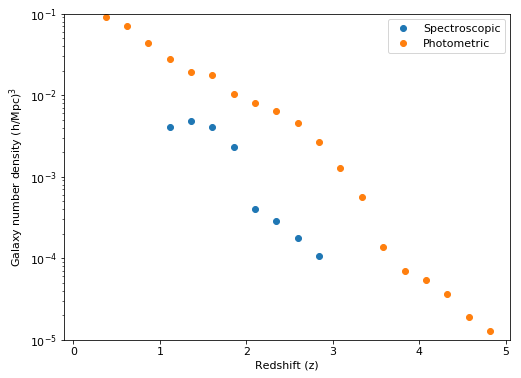

In [3]:
plt.plot(z, n_spec,'o', label='Spectroscopic')
plt.plot(z, n_phot,'o', label='Photometric')
plt.xlabel('Redshift (z)')
plt.ylabel('Galaxy number density (h/Mpc)$^3$')
plt.legend(loc='best')
plt.yscale('log')
plt.ylim(10**(-5), 10**(-1))
plt.show()

### Set fiducial cosmology

In [4]:
fid_params={'h':[0.675], 'Omb':[0.048], 'Omc':[0.268], 'ns':[0.965], 'As':[2e-09], 'w':[-1.0]}
print 'Fiducial Parameters:', fid_params

#List of fiducial parameters:
params_f=[p[0] for p in fid_params.itervalues()]

n_pts=200
f_sky=0.048

Fiducial Parameters: {'Omc': [0.268], 'Omb': [0.048], 'h': [0.675], 'As': [2e-09], 'w': [-1.0], 'ns': [0.965]}


### Specify parameters to vary and step size

In [5]:
step_dict={'Omb':[0.002], 'Omc':[0.003], 'ns':[0.01], 'As':[5e-11], 'w':[0.03]}
#step_dict={'Omc':[0.003], 'w':[0.03]}

print 'Parameters to vary and step size:',step_dict

Parameters to vary and step size: {'Omc': [0.003], 'Omb': [0.002], 'As': [5e-11], 'ns': [0.01], 'w': [0.03]}


In [6]:
def list_params(Step_dict, Fid_params):
    step_keys=[key for key in Step_dict.iterkeys()]
    keys=[p for p in Fid_params.iterkeys()]

    Params=copy.deepcopy(Fid_params)

    for i in keys:
        if i in step_keys:
            Params[i].append(Fid_params[i][0]+Step_dict[i][0])
            Params[i].append(Fid_params[i][0]-Step_dict[i][0])
        Params[i].sort()
    return [Params[i] for i in keys], keys, step_keys

params_list, keys, step_keys=list_params(step_dict, fid_params)
print 'Cosmological parameters that will be used:', params_list

Cosmological parameters that will be used: [[0.265, 0.268, 0.271], [0.046, 0.048, 0.05], [0.675], [1.95e-09, 2e-09, 2.05e-09], [-1.03, -1.0, -0.97], [0.955, 0.965, 0.975]]


### Calculate matter power spectrum for various cosmologies

In [7]:
def Power_spectrum(param, Z_bin, K_max):
    Omc, Omb, h, A_s, w, n_s = param
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100.*h, ombh2=Omb*(h**2), omch2=Omc*(h**2.), omk=0)
    pars.set_dark_energy(w)
    pars.InitPower.set_params(As= A_s, ns=n_s)
    pars.set_matter_power(redshifts=Z_bin, kmax=2.0)

    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-3, maxkh=K_max, npoints = n_pts)
    t = results.get_matter_transfer_data()
    
    qt=t.transfer_data[0, :, 0]
    transf=[]
    for i in range(len(Z_bin)):
        transf_interp=interp1d(qt, t.transfer_data[6, :, i])
        transf.append(transf_interp(kh))
    
    if param==params_f:
        res_fid = camb.get_results(pars)
        t_fid = res_fid.get_matter_transfer_data()

        qt_fid=t_fid.transfer_data[0, :, 0]
        transf_fid=[]
        for i in range(len(Z_bin)):
            interp_fid=interp1d(qt_fid, t_fid.transfer_data[6, :, i])
            transf_fid.append(interp_fid(kh)) 
            
        pars.set_matter_power(redshifts=[0.0], kmax=2.0)
        pars.NonLinear = model.NonLinear_none
        results2 = camb.get_results(pars)
        s8=results2.get_sigma8()        
        return kh, pk, res_fid, np.array(transf_fid)[::-1,:], s8
    
    pars.set_matter_power(redshifts=[0.0], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results2 = camb.get_results(pars)
    s8=results2.get_sigma8()
    return kh, pk, np.array(transf)[::-1,:], s8

def calculate_PS(Params_list, Params_f, n_params, print_steps, Z_bin, K_max):
    PS=np.zeros((2*n_params,len(Z_bin), n_pts))
    transf=np.zeros((2*n_params,len(Z_bin), n_pts))
    Omega_m=[]; W=[]; sig8=[]

    l=0; vary=[]
    for i in range(len(Params_list)):
        for j in range(len(Params_list[i])):
            if len(Params_list[i])>1:
                par=list(Params_f)
                par[i]=Params_list[i][j]
                if par!=Params_f:
                    vary.append(Params_list[i][j])
                    k, PS[l], transf[l], S8 =Power_spectrum(par, Z_bin, K_max)
                    sig8.append(S8)

                    l+=1
                    if print_steps:
                        print 'Parameters: (%s,%s)'%(i, j), par
                    Omega_m.append(par[0]+par[1])
                    W.append(par[4])
    return k, PS, transf, vary, Omega_m, W, sig8

k, PS, Transf, vary, omg_m, w, sigma8=calculate_PS(params_list, params_f, len(step_dict), False, z, 0.2)

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


### Fiducial Case

In [8]:
k, PS_fid, res_fid, Transf_fid, s8_fid=Power_spectrum(params_f, z, 0.2)
H_bar = np.array([res_fid.h_of_z(i) for i in z])/(0.675)
r_z=np.array([res_fid.comoving_radial_distance(i) for i in z])*(0.675)
c=299792.
print 'H(z)=', H_bar*c*0.675

Note: redshifts have been re-sorted (earliest first)
H(z)= [  71.8840287    82.72594443   96.16201412  111.84406116  129.46283182
  148.77136065  169.57947346  191.74129114  215.14363315  239.69710357
  265.32967115  291.98214066  319.60496132  348.15595847  377.59870005
  407.90130216  439.03554173  470.97618679  503.70048313  537.18775496]


## Photometric and Spectroscopic Bispectrum

The bispectrum predicted by tree-level perturbation theory is given by

\begin{equation}
B(k_1, k_2, k_3) = 2F_2({\bf k}_1, {\bf k}_2) P(k_1) P(k_2) + \text{cyc.}
\end{equation}
where,

\begin{equation}
F_2({\bf k}_1, {\bf k}_2) = \frac{5}{7} + \frac{\hat{{\bf k}}_1 \cdot \hat{{\bf k}}_2}{2} \left( \frac{k_1}{k_2} + \frac{k_2}{k_1} \right) + \frac{2}{7} \left(\hat{{\bf k}}_1 \cdot \hat{{\bf k}}_2\right)^2 .
\end{equation}

The bispectrum including two objects from the spectroscopic sample and one from the photometric sample is

\begin{equation}
B_{pss}(k_1, k_2, k_3) = \text{e}^{- \frac{1}{2} k^2_1 \mu^2_1 \sigma^2_z/ H^2} B(k_1, k_2, k_3)
\end{equation}

In [9]:
def F_2(a,b,c):
    cos=-(a**2. + b**2. -(c**2.))/(2.*a*b)
    return 5./7. + ((a*b*cos)/(2.*a*b))*((a/b) + (b/a)) + (2./7.)*(((a*b*cos)/(a*b)))**2.

def exp_z(K, Mu, Sigma_z, H):
    exp=(np.exp(-(((K)**2.)*np.outer((((Sigma_z)**2.)/(2.*(H**2.))), ((Mu)**2.)))))
    return exp

def Bispectrum(K1, K2, Mu, Sigma_z):
    K3=np.linspace((K1-K2), K1+K2 , 200)
    #Q_ssp=np.zeros((len(K3)))
    B_ssp=np.zeros((len(K3), len(Mu)))
    B_sss=np.zeros((len(K3)))

    for l in range(len(K3)):
        B_sss[l]=(2.*F_2(K1, K2, K3[l])*fid_interp(K1)*fid_interp(K2) 
                  + 2.*F_2(K2, K3[l], K1)*fid_interp(K2)*fid_interp(K3[l]) 
                  + 2.*F_2(K3[l], K1, K2)*fid_interp(K3[l])*fid_interp(K1))
        B_ssp[l]=exp_z(K3[l], Mu, Sigma_z, 67.5/c)*(2.*F_2(K1, K2, K3[l])*fid_interp(K1)*fid_interp(K2) 
                    + 2.*F_2(K2, K3[l], K1)*fid_interp(K2)*fid_interp(K3[l]) 
                    + 2.*F_2(K3[l], K1, K2)*fid_interp(K3[l])*fid_interp(K1))
        #Q_test[l]=B_test[l]/(fid_interp(K1)*fid_interp(K2) + fid_interp(K2)*fid_interp(K3[l]) 
        #                    + fid_interp(K1)*fid_interp(K3[l]))
        
    return B_ssp, B_sss

#### Bispectrum suppression due to photometric errors

In [10]:
k0, PS_fid0, _, _, _=Power_spectrum(params_f, [0.0], 0.8)

fid_interp = interp1d(k0, PS_fid0, kind='cubic')

theta=np.linspace(0, np.pi, 100)
mu=np.cos(theta)
sig_z=np.array(0.04*(1.+z))

Bssp, Bsss=Bispectrum(0.04, 0.039, mu, 0.005)
Bssp2, _=Bispectrum(0.04, 0.039, mu, 0.05)

Psp_fid = np.zeros((len(k0), len(mu)))
Psp_fid2 = np.zeros((len(k0), len(mu)))
for i in range(len(mu)):
    Psp_fid[:,i]=PS_fid0*exp_z(k0, mu[i], 0.005, 67.5/c)
    Psp_fid2[:,i]=PS_fid0*exp_z(k0, mu[i], 0.05, 67.5/c)

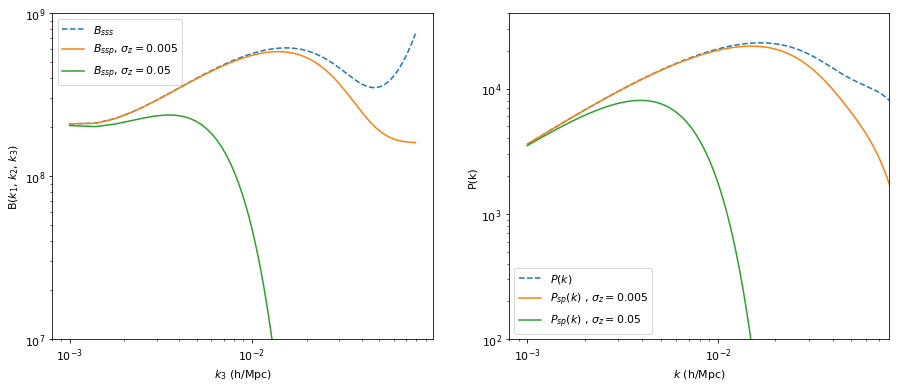

In [11]:
plt.rcParams['figure.figsize'] = (15, 6)

def angle(a,b,c):
    return math.acos(-(a**2. + b**2. -(c**2.))/(2.*a*b))

k3=np.linspace((0.04-0.039), 0.04+0.039 , 200)
ang=[angle(0.04,0.039,i)/np.pi for i in k3]

plt.subplot(121)
plt.loglog(k3, Bsss,'--', label=r'$B_{sss}$')
plt.loglog(k3, Bssp[:,0], label=r'$B_{ssp}$, $\sigma_z=0.005$')
plt.loglog(k3, Bssp2[:,0], label=r'$B_{ssp}$, $\sigma_z=0.05$')
plt.xlabel(r'$k_3$ (h/Mpc)')
plt.ylabel(r'B($k_1$, $k_2$, $k_3$)')
plt.yscale('log')
plt.legend(loc='best')
plt.ylim(10**(7), 10**9)
 
plt.subplot(122)
plt.loglog(k0, PS_fid0[0],'--', label=r'$P(k)$')
plt.loglog(k0, Psp_fid[:,0], label=r'$P_{sp}(k)$ , $\sigma_z = 0.005$')
plt.loglog(k0, Psp_fid2[:,0], label=r'$P_{sp}(k)$ , $\sigma_z = 0.05$')
plt.ylim(10**2, 4*10**4)
plt.xlim(0.0008, 0.079)
plt.legend(loc='best')
plt.xlabel(r'$k$ (h/Mpc)')
plt.ylabel(r'P(k)')
plt.show()

## Photometric and Spectroscopic Fisher matrix

In [12]:
def E(A, omg_m, omg_de, w):
    return np.sqrt((omg_m/(A**3.) + omg_de/(A**(3.*(1.+w)))))

def growth1(A, omg_m, omg_de, w):
    a2=np.linspace(10**(-7), A, 200)
    e=np.array([E(i, omg_m, omg_de, w) for i in a2])
    return 2.5*omg_m*E(A, omg_m, omg_de, w)*integrate.simps((a2*e)**(-3.), a2)

def M(K, T, D, Omg_m):
    return -(3./5.)*(((K**2.)*T*D)/(Omg_m*((100./c)**2.)))

f_nl=[0.8- 0.8*1., 0.8 +0.8*1.]

D_z=np.zeros((len(vary), len(z)))
D_fid=[growth1(i, 0.316 , (1.-0.316), -1.) for i in (1./(1.+z))]

for i in range(len(vary)):
    for j in range(len(z)):
        a=1./(1.+z[j])
        D_z[i][j]=growth1(a, omg_m[i], (1.-omg_m[i]), w[i])

Transf_norm=np.zeros(Transf.shape)
Tfid_norm=np.array([Transf_fid[i,:]/Transf_fid[i,0] for i in range(len(z))])

for i in range(len(Transf)):
    for j in range(len(Transf[i])):
        Transf_norm[i][j]=Transf[i,j,:]/Transf[i,j,0]

In [13]:
PS2=np.zeros((2*len(step_dict),len(z), n_pts))
for i in range(len(PS)):
        PS2[i]=(PS[i])*((s8_fid/sigma8[i])**2.)
        
PS2[4]=(PS_fid[:,:])*(((s8_fid - s8_fid*0.01)/sigma8[4])**2.)
PS2[5]=(PS_fid[:,:])*(((s8_fid + s8_fid*0.01)/sigma8[5])**2.)

vary[4]=s8_fid - s8_fid*0.01
vary[5]=s8_fid + s8_fid*0.01

The Fisher matrix including $B_{sss}$ and $B_{ssp}$ is given by

\begin{equation}
F_{lm} = \int dk_1 \int dk_2 \int dk_3\ 4\pi f_{sky} \int^{z_{max}}_{z_{min}} dz \frac{r^2(z)}{H(z)} \int \frac{d \mu_1}{2} \sum_{\alpha, \beta} \frac{\partial B_{\alpha}(z)}{\partial p_l} \frac{\partial B_{\beta}(z)}{\partial p_m} \text{Cov}^{-1}\left[ B_{\alpha}, B_{\beta} \right],
\end{equation}

where $\alpha, \beta = sss, pss$ and 

\begin{split}
\text{Cov}\left[ B_{sss}, B_{sss} \right] &= \frac{\pi (2\pi)^3 P_{ss}(k_1) P_{ss}(k_2) P_{ss}(k_3)}{k_1 k_2 k_3} \\
\text{Cov}\left[ B_{sss}, B_{pss} \right] &= \frac{\pi (2\pi)^3 P_{sp}(k_1) P_{ss}(k_2) P_{ss}(k_3)}{k_1 k_2 k_3} \\
\text{Cov}\left[ B_{pss}, B_{pss} \right] &= \frac{\pi (2\pi)^3 P_{pp}(k_1) P_{ss}(k_2) P_{ss}(k_3)}{k_1 k_2 k_3} \\
\end{split}

In [15]:
def B_total(a,b,c, P_a, P_b, P_c, M_a, M_b, M_c, F_nl):
    B_G=(2.*F_2(a,b,c)*P_a*P_b + 2.*F_2(b,c,a)*P_b*P_c + 2.*F_2(c,a,b)*P_c*P_a)
    B_L=(2.*F_nl*((1./M_a)*(1./M_b)*M_c*P_a*P_b + (1./M_b)*(1./M_c)*M_a*P_b*P_c + (1./M_a)*(1./M_c)*M_b*P_a*P_c))
    B_sss=(B_G + B_L)
    return B_sss

def Derivative(Vary, Bisp, Z_bin, Mu):
    dBisp = np.zeros((len(Vary)/2, len(Z_bin), len(Mu)))
    for i in range(len(Vary)/2):
        dBisp[i,:,:]=(Bisp[2*i+1,:,:]-Bisp[2*i,:,:])/(Vary[2*i+1]-Vary[2*i])
    return dBisp

def Fisher(K, Mu, P, P_fid, Rz, F_sky, redshift, Hz, Nz_spec, Nz_phot, Vary, Sigma_z, Omg_m, F_nl):
    Omg_m2=np.outer(Omg_m, np.ones((len(redshift))))
    P_reshaped=(P_fid.reshape(len(redshift), 1, len(K)))*np.ones((len(redshift), len(Mu), len(K)))
    N_spec=(Nz_spec.reshape((len(redshift),1)))*np.ones((len(redshift),len(Mu)))
    N_phot=(Nz_phot.reshape((len(redshift),1)))*np.ones((len(redshift),len(Mu)))
    R_H=((Rz**2.)/Hz).reshape(20,1)

    F=np.zeros((len(Vary)/2 +1, len(Vary)/2 +1))
    for p in range(len(Vary)/2 +1):
        for q in range(p,len(Vary)/2 +1):
            integrand3=[]
            for i in range(len(K)):
                integrand2=[]
                k2=[]
                for j in range(i,len(K)):
                    k2.append(K[j])
                    integrand1=[]
                    k1=[]
                    for l in range(j,len(K)):
                        k_lim=min((K[i]+K[j]), max(K))
                        if K[l]<=k_lim:
                            k1.append(K[l])
                            B_tot=np.array(B_total(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l], M(K[i], Transf_norm[:,:,i], D_z[:,:], Omg_m2[:,:]), M(K[j], Transf_norm[:,:,j], D_z[:,:], Omg_m2[:,:]), M(K[l], Transf_norm[:,:,l], D_z[:,:], Omg_m2[:,:]), 0.8))
                            B_tot=np.vstack((B_tot, (B_total(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[0]).reshape((1, len(redshift))))))
                            B_tot=np.vstack((B_tot, (B_total(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[1]).reshape((1, len(redshift))))))
                            B_tot=(B_tot.reshape(len(Vary)+2,len(redshift),1)*np.ones((len(Vary)+2,len(redshift),len(Mu))))

                            deriv_sss=Derivative(np.concatenate((Vary, F_nl)), B_tot, redshift, Mu)
                            deriv_ssp=Derivative(np.concatenate((Vary, F_nl)), ((exp_z(K[i], Mu, Sigma_z, Hz).reshape(1,len(redshift), len(Mu)))*(B_tot)), redshift, Mu)

                            Cov=np.zeros((len(redshift),len(Mu),2,2))
                            Cov[:,:,0,0] = (8.*np.pi**4.)*((P_reshaped[:,:,i]+(1./N_spec))*(P_reshaped[:,:,j]+(1./N_spec))*(P_reshaped[:,:,l]+(1./N_spec)))/(K[i]*K[j]*K[l])                               
                            Cov[:,:,1,1] = (8.*np.pi**4.)*(((P_reshaped[:,:,i]*(exp_z(K[i], Mu, Sigma_z, Hz)**2.))+(1./N_phot))*(P_reshaped[:,:,j]+(1./N_spec))*(P_reshaped[:,:,l]+(1./N_spec)))/(K[i]*K[j]*K[l])
                            Cov[:,:,0,1] = (8.*np.pi**4.)*((P_reshaped[:,:,i]*(exp_z(K[i], Mu, Sigma_z, Hz)))*(P_reshaped[:,:,j]+(1./N_spec))*(P_reshaped[:,:,l]+(1./N_spec)))/(K[i]*K[j]*K[l])
                            Cov[:,:,1,0] = Cov[:,:,0,1]
                            Cov_inv=np.linalg.inv(Cov)
                            integrand_z= 2.*np.pi*F_sky*(R_H)*(Cov_inv[:,:,0,0]*deriv_sss[p,:,:]*deriv_sss[q,:,:] + 2.*Cov_inv[:,:,0,1]*deriv_sss[p,:,:]*deriv_ssp[q,:,:] + Cov_inv[:,:,1,1]*deriv_ssp[p,:,:]*deriv_ssp[q,:,:])
                            
                            integrand_mu = integrate.simps(integrand_z, redshift, axis=0)
                            integrand1.append(integrate.simps(-np.array(integrand_mu), Mu, axis=0))
                    integrand2.append(integrate.simps(integrand1, k1))
                integrand3.append(integrate.simps(integrand2, k2))
            F[p][q]=integrate.simps(integrand3, K)
            F[q][p]=F[p][q]
    return F

F_ssp=Fisher(k, mu, PS2, PS_fid, r_z, f_sky, z, H_bar, n_spec, n_phot, vary, sig_z, omg_m, f_nl)

### Comparison between spectroscopic only and spectroscopic + photometric

In [16]:
Fsss=np.zeros((len(vary)/2 +1, len(vary)/2 +1))

f=open('Bsss.txt',"r")
lines=f.readlines()
for x in lines:
    i=int(x.split(',')[0])
    j=int(x.split(',')[1])
    Fsss[i,j] = float(x.split(',')[2])
    Fsss[j,i] = Fsss[i,j]
f.close()

M=np.array([[1., 1.,  0., 0., 0., 0.], [-1., 1., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 1.]])
Fsss_new=np.dot(M.T,np.dot(Fsss, M))
sss_inv=np.linalg.inv(Fsss_new)
sss_marg=[[sss_inv[0,0], sss_inv[0,2]], [sss_inv[2,0], sss_inv[2,2]]]

Fssp=np.zeros((len(vary)/2 +1, len(vary)/2 +1))
f=open('Bssp.txt',"r")
lines=f.readlines()
for x in lines:
    i=int(x.split(',')[0])
    j=int(x.split(',')[1])
    Fssp[i,j] = float(x.split(',')[2])
    Fssp[j,i] = Fssp[i,j]
f.close()

Fssp_new=np.dot(M.T,np.dot(Fssp, M))
ssp_inv=np.linalg.inv(Fssp_new)
ssp_marg=[[ssp_inv[0,0], ssp_inv[0,2]], [ssp_inv[2,0], ssp_inv[2,2]]]

In [17]:
step_keys[2] = 's8'; step_keys[0] = 'Om'
step_keys.append('f_nl')
Mp = pd.DataFrame(np.vstack((np.sqrt(np.diag(sss_inv)), np.sqrt(np.diag(ssp_inv)))), index=['sss', 'ssp'], columns=step_keys)
print Mp

           Om       Omb        s8        ns         w       f_nl
sss  0.004793  0.004036  0.037857  0.076008  0.026073  13.255677
ssp  0.004360  0.003671  0.029212  0.060075  0.023726  11.891431


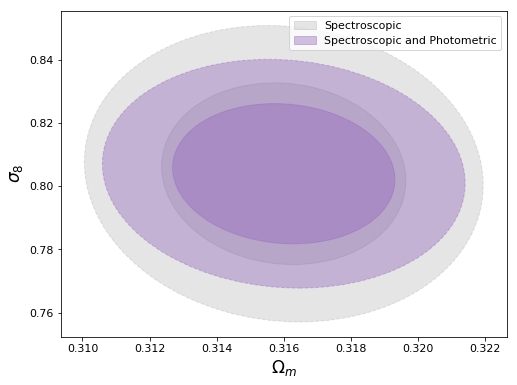

In [18]:
from matplotlib.patches import Ellipse
import matplotlib

plt.rcParams['figure.figsize'] = (8, 6)
def ellipse_plot(inv_fisher, mean_x, mean_y, xname, yname, fig, ax, co, label, opacity):
    alpha1 = 1.52
    alpha2 = 2.48
    sigma_x2 = inv_fisher[0][0]
    sigma_y2 = inv_fisher[1][1]
    sigma_xy = inv_fisher[0][1]
    
    a2 = (sigma_x2 + sigma_y2)/2. + np.sqrt((sigma_x2 - sigma_y2)**2/4. + sigma_xy**2)
    b2 = (sigma_x2 + sigma_y2)/2. - np.sqrt((sigma_x2 - sigma_y2)**2/4. + sigma_xy**2)

    tan2theta = 2.*(sigma_xy)/(sigma_x2 - sigma_y2)
    ang = 0.5*np.arctan(tan2theta)
    
    ell = matplotlib.patches.Ellipse(xy = [mean_x, mean_y], height = alpha1*np.sqrt(a2), width = alpha1*np.sqrt(b2), angle = np.degrees(ang), fill=True, color=co, label=label)
    ell2 = matplotlib.patches.Ellipse(xy = [mean_x, mean_y], height = alpha2*np.sqrt(a2), width = alpha2*np.sqrt(b2), angle = np.degrees(ang), fill=True, ls='--', color=co)
    ell.set_alpha(opacity)
    ell2.set_alpha(opacity)
    
    ax.add_patch(ell)
    ax.add_patch(ell2)
    ax.autoscale()
    ax.set_xlabel(xname, fontsize=17)
    ax.set_ylabel(yname, fontsize=17)
    ax.legend(loc='best')
    
mu_m=0.316
mu_s8=0.804

fig, ax = plt.subplots()

ellipse_plot(sss_marg, mu_m, mu_s8, r'$\Omega_m$', r'$\sigma_8$', fig, ax, 'C7','Spectroscopic', 0.2)
ellipse_plot(ssp_marg, mu_m, mu_s8, r'$\Omega_m$', r'$\sigma_8$', fig, ax, 'C4', 'Spectroscopic and Photometric', 0.4)

#### Dependence on the number of k bins (squeezed limit)

In [19]:
scdm_log = np.sqrt(1./loadtxt("scdm_log_squeezed.txt",usecols=1,  comments="#", delimiter=",", unpack=False))
sfnl_log = np.sqrt(1./np.loadtxt("sfnl_log_squeezed.txt", comments="#", delimiter=",", unpack=False))
scdm_linear = np.sqrt(1./loadtxt("scdm_linear_squeezed.txt",usecols=1,  comments="#", delimiter=",", unpack=False))
sfnl_linear = np.sqrt(1./np.loadtxt("sfnl_linear_squeezed.txt", comments="#", delimiter=",", unpack=False))

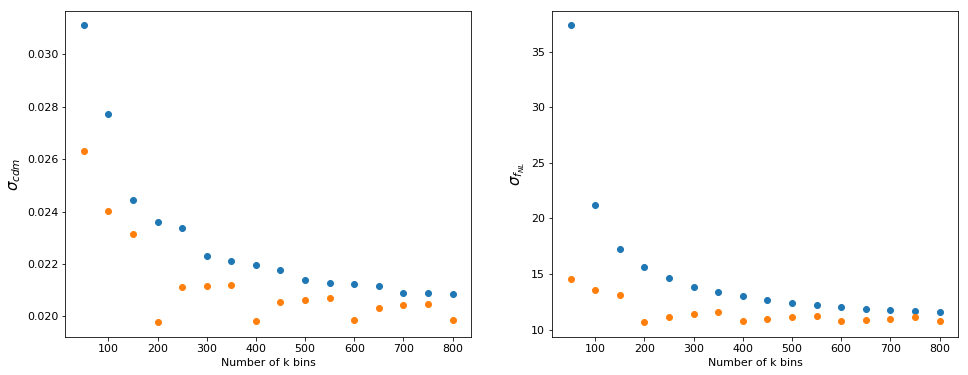

In [20]:
x=np.arange(50, 850, 50)

plt.rcParams['figure.figsize'] = (16, 6)

plt.subplot(121)
plt.plot(x, scdm_log, 'o', label='Logarithmic bins')
plt.plot(x, scdm_linear, 'o', label= 'Linear bins')
plt.xlabel('Number of k bins')
plt.ylabel(r'$\sigma_{cdm}$', fontsize=15)


plt.subplot(122)
plt.plot(x, sfnl_log, 'o', label='Logarithmic bins')
plt.plot(x, sfnl_linear, 'o', label='Linear bins')
plt.xlabel('Number of k bins')
plt.ylabel(r'$\sigma_{f_{NL}}$', fontsize=15)

plt.show()

#### Dependence on $\sigma_z$

$$ \sigma = \alpha \cdot \sigma_z $$

In [21]:
sz_fnl = 1./np.sqrt(np.loadtxt("sfnl_varysz.txt", usecols=1, delimiter=', ', comments="#", unpack=False))

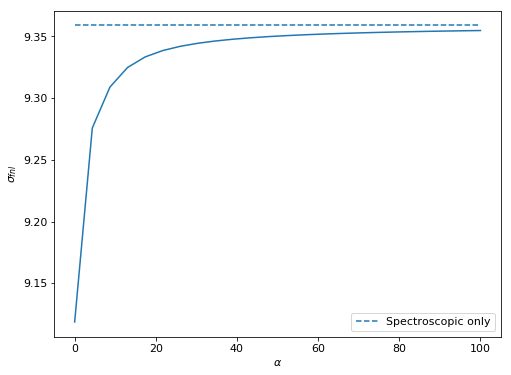

In [22]:
plt.rcParams['figure.figsize'] = (8, 6)
a=np.linspace(.01, 100., 24)
plt.plot(a, (1./np.sqrt(0.011416869967347747))*np.ones((len(a))), 'C0--', label='Spectroscopic only')
plt.plot(a, sz_fnl)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\sigma_{fnl}$')
plt.legend()
plt.show()